In [1]:
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import uproot
import hist


In [2]:
# HEPHY topside
x = np.arange(60, 86) #thr 
x = np.arange(174, 186) #HV 190-25
x = np.concatenate((np.arange(174, 176),np.arange(177, 180),np.arange(181, 186))) #HV gefiltert

# HEPHY backside
x = np.arange(206, 231) #thr 
x = np.arange(234, 248) #HV 200-5
x = np.arange(251, 256) #HV 450-250
x = np.arange(271, 280) #HV 10-2
x = np.concatenate((np.arange(234, 248), np.arange(251, 256), np.arange(271, 280))) #HV all

# NIKHEF backside
x = np.arange(308, 318) #HV 20-2
x = np.arange(322, 332) #HV 500-50
x = np.concatenate((np.arange(308, 318), np.arange(322, 332))) #HV all

# Liverpool topside
x = np.arange(342, 367) #thr
x = np.arange(372, 466) #HV 500-50
x = np.concatenate((np.arange(372, 410), np.arange(411, 437), np.arange(438, 466))) #HV 500-50 ohne error

# NIKHEF backside_top
x = np.arange(495, 507) #thr
x = np.arange(468, 480) #HV 190-80
x = np.arange(480, 494) #HV 70-5
x = np.concatenate((np.arange(468, 480), np.arange(480, 494))) #HV all



In [3]:
# Use glob to find all files matching the pattern 'hv_vs_effi/logs/*log*.txt'
logs = glob.glob('logfiles_old/*.log')

# Initialize a dictionary 'effis' to store efficiency-related data
effis = {'Efficiency': [], 'Err+': [], 'Err-':[], 'Bias':[]}
run_map_file = '/home/harald/Desktop/MPW4/desy_04_24/all_data.csv'
run_map = {}

output_file = '/home/harald/Desktop/MPW4/desy_04_24/plots/effi_vs_threshold.png'
plot_title = 'Efficiency vs. Threshold'
x_label ='Threshold [mV]'

# output_file = '/home/harald/Desktop/MPW4/desy_04_24/plots/effi_vs_bias.png'
# plot_title = 'Efficiency vs. Bias'
# x_label ='Bias [V]'


#runs_to_analyse =  np.arange(174, 186)

runs_to_analyse =  np.arange(495, 507)
#ax_start = 30
#ax_end = 102


logs.sort()
filesToRemove = []
for r in logs:
    match = re.search(r'analysis_jobsub_(\d+)', r)
    if match:
        runNmb = int(match.group(1))
        if not (runNmb in runs_to_analyse):
            filesToRemove.append(r)
    else:
        filesToRemove.append(r)

for f in filesToRemove:
    logs.remove(f)

with open(run_map_file) as f:
    for line in f:
        if line.startswith('#'):
            continue
        run, para = line.split(',')
        run = int(run)
        para = abs(float(para))
        run_map[run] = para

#run_map



In [4]:
logs.sort()

# Loop through each file found by glob
for f in logs:
    with open(f) as log:  # Open the file for reading
        for line in log:  # Loop through each line in the file

            # Use regular expressions to search for a pattern in the line
            # Explanation of the regex pattern:
            # (?<=Total efficiency ) - Positive lookbehind for "Total efficiency "
            # .+ - Match one or more of any character (except newline)
            # (\d\d\.\d+) - Capture a numerical value in the format of two digits, a dot, and one or more digits (Efficiency)
            # \(.(0.\d+) .(0.\d+)' - Capture two numerical values in parentheses (Err+ and Err-)
            match = re.search(r'(?<=Total efficiency )(.+(\d\d\.\d+)\(.(0.\d+) .(0.\d+))', line)
            #print(match)
            
            if not match:
                continue  # If no match is found, skip to the next line

            runNmb = int(re.search(r'analysis_jobsub_(\d+)', f).group(1))
            # Extract and store data based on the regular expression groups
            effis['Bias'].append(run_map[runNmb])  # Extract 'Bias' from the file name
            effis['Efficiency'].append(float(match.group(2)))  # Extract 'Efficiency' value
            effis['Err+'].append(float(match.group(3)))  # Extract 'Err+' value
            effis['Err-'].append(float(match.group(4)))  # Extract 'Err-' value

df = pd.DataFrame(effis)
#df

In [5]:
# Define a list of ROOT files to open
root_file_list = glob.glob('/home/harald/Desktop/MPW4/desy_04_24/output/data_old/*.root')

# Define a list of keys (TKeys) to extract data from
#efficiency not working properly, TEfficiency sucks
keys_to_extract = [["EventLoaderEUDAQ2/RD50_MPWx_base_0/hPixelRawValues", "ToT (LSB)"],
        ["ClusteringSpatial/RD50_MPWx_base_0/clusterSize", "Cluster size"],
        ["AnalysisDUT/RD50_MPWx_base_0/local_residuals/residualsX", r"Spatial Resolution X ($\mu m$)"],
        ["AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/hFakePixelPerEvent", "Fake Rate"]]

run_map = {}

x_name = 'Bias (mV)'

root_file_list.sort()
filesToRemove = []
for r in root_file_list:
    match = re.search(r'(\d+)\.root', r)
    if match:
        runNmb = int(match.group(1))
        if not (runNmb in runs_to_analyse):
            filesToRemove.append(r)
    else:
        filesToRemove.append(r)

for f in filesToRemove:
    root_file_list.remove(f)
    
root_file_list.sort()
#root_file_list

In [6]:
with open(run_map_file) as f:
    for line in f:
        if line.startswith('#'):
            continue
        run, para = line.split(',')
        run = int(run)
        para = abs(float(para))
        run_map[run] = para

#run_map

In [7]:
# Create an empty DataFrame to store the results
# results_df = pd.DataFrame(columns=["File", "Key", "Mean", "StdDev"])
results = {"File" : [], "Key" : [], "Name" : [], "xVal" : [], "Mean" : [], "StdDev": [], "StdErr" : [], "N" :[] }

# Loop over each ROOT file
for root_file in root_file_list:
    # Open the ROOT file using uproot
    with uproot.open(root_file) as file:
        # Loop over each key to extract data
        for key_name in keys_to_extract:
            try:
                # Access the TKey using the key name
                tkey = file[key_name[0]]
                # print(tkey)
                mean_val = 0
                std_dev_val = 0
                N = 0
                # Check if the TKey points to a TH1F histogram
                if isinstance(tkey, uproot.uproot.behaviors.TH1.TH1):                    
                    hist_np = tkey.to_numpy() # [0] ... bins, [1] ... weights
                    # hist_data = tkey.to_hist()
                    # hist_data.plot()
                    # plt.show()
                        
                    unjagged_bins = (hist_np[1][:-1] + hist_np[1][1:]) / 2
                    
                    N = np.sum(hist_np[0])
                    mean_val = np.sum(hist_np[0] * unjagged_bins) / N
                    #print('mean = ', mean_val)                    
                    std_dev_val = np.sqrt(np.sum(hist_np[0] * (unjagged_bins - mean_val)**2) / N)

                    #hacky special treatment
                    if 'hPixelRawValues' in key_name[0]:
                        mask = unjagged_bins < 100
                        N = np.sum(hist_np[0][mask])
                        mean_val = np.sum(hist_np[0][mask] * unjagged_bins[mask]) / N
                        std_dev_val = np.sqrt(np.sum(hist_np[0][mask] * (unjagged_bins[mask] - mean_val)**2) / N)
                    #print('std', std_dev_val)
                elif isinstance(tkey, uproot.uproot.behaviors.TProfile2D.TProfile2D):
                    # print('encountered a', tkey)
                    vals = tkey.values()
                    # print(vals, np.average(vals))
                    mean_val = np.average(vals)
                    std_dev_val = np.std(vals)
                    N = 1
                else:
                    continue

                runNmb = int(re.search(r'(\d+)\.root', root_file).group(1))
                results["xVal"].append(run_map[runNmb])
                results["Mean"].append(mean_val)
                results['StdDev'].append(std_dev_val)
                results['File'].append(root_file)
                results['Key'].append(key_name[0])
                results['Name'].append(key_name[1])
                results["N"].append(N)
                results["StdErr"].append(std_dev_val / np.sqrt(N))

            except KeyError:
                print(f"Key '{key_name}' not found in file '{root_file}'")

df_root = pd.DataFrame(results)
#df_root

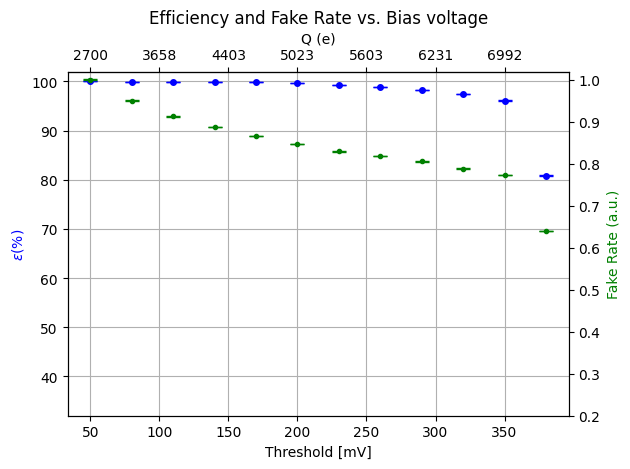

In [8]:
df = df.sort_values(by='Bias')

fig, ax1 = plt.subplots()
plt.title("Efficiency and Fake Rate vs. Bias voltage")


# Create the efficiency plot with error bars
ax1.errorbar(df['Bias'], df['Efficiency'], yerr=[df['Err-'], df['Err+']], fmt='.', color='blue', markersize=8, capsize=5, label='Efficiency with Error Bars')
ax1.set_xlabel(x_label)
ax1.set_ylabel(r'$\epsilon$(%)', color = 'blue')
ax1.set_ylim(32,102)
ax1.grid(True)

# Annotate efficiency with Bias values
# for i, row in df.iterrows():
#     ax1.annotate(f'{row["Efficiency"]:.2f}', (row['Bias'], row['Efficiency']), textcoords="offset points", xytext=(5,5), ha='center')

# Create plot for fake rate
ax2 = ax1.twinx()
i = 3
key = ['AnalysisEfficiency/RD50_MPWx_base_0/fake_rate/hFakePixelPerEvent', 'Fake Rate']
keyrows = df_root[df_root['Key'].str.contains(key[0])]
x = keyrows['xVal'] 
y = keyrows['Mean']
y = y/np.max(y) #Normierung Fake Rate
# hacky special treatment
if 'residuals' in key[0]:
    y = keyrows['StdDev']
yerr = df_root[df_root['Key'].str.contains(key[0])]['StdErr'].values

#Plot Fake Rate with error bars
ax2.set_ylabel(key[1]+' (a.u.)',color='green')
ax2.errorbar(x, y, yerr=yerr, fmt='.', color='green', capsize=5)  # Add error bars
ax2.set_ylim(bottom=0.2)

#Create second x-axis
ax3 = ax1.secondary_xaxis("top")
ax3.set_xticks(ax1.get_xticks())
ax3.set_xbound(ax1.get_xbound())
ax3.set_xticklabels([round((6.61133080e-06*np.power(x,3)-4.41590811e-03*np.power(x,2)+1.64285116e+00*x+8.25602665e+01)*2.8*6.242) for x in ax1.get_xticks()])
#ax3.set_xticklabels([round((x * 0.809 + 120.71)*2.8*6.242) for x in ax1.get_xticks()]) #linear fit
ax3.set_xlabel("Q (e)")

fig.tight_layout()


# Show the plot
fig.savefig(output_file)
#fig.show()
